# A Simple Convolutional AutoEncoder Implementation

In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

import os
import random

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
# verify gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3275934748657929261
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6762114908
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2775413201449681402
physical_device_desc: "device: 0, name: GeForce GTX 980M, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [4]:
###### Constants ######
BATCH_SIZE=128
MAX_EPOCHS=100
PERCENT_VAL=0.2 # percentage of test data used for validation

# Autoencoder Parameters
LATENT_DIM = 10
INPUT_SHAPE = (28, 28, 1)

# Save/Load Model Constants
SAVE_PATH = os.path.join('..', 'models', 'conv_autoencoder')

LOADING_WEIGHTS = True
SAVING_WEIGHTS = False
TRAINING = False

In [5]:
###### Function Definitions ######
def normalize(images, labels):
    # Add channel
    images = tf.expand_dims(images, -1)
    images = tf.cast(images, tf.float32)
    images /= 255
    
    # Add channel
    labels = tf.expand_dims(labels, -1)
    labels = tf.cast(labels, tf.float32)
    labels /= 255
    
    return images, labels

def display_image(image):
    image = image if type(image) is np.ndarray else image.numpy()
    image = image.reshape((28,28))
    plt.figure(figsize=(2,2))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.colorbar()
    plt.grid(False)
    plt.show()

# TODO: Add ability to pass associated labels or titles (for example, simularity scores)
def display_images(images, rows, cols, dpi=128, wspace=0, hspace=0, labels=None):
    fig = plt.figure(dpi=dpi)

    spec = gs.GridSpec(rows, cols)
    spec.update(wspace=wspace, hspace=hspace)

    i = 0
    for image in images:
        image = image if type(image) is np.ndarray else image.numpy()
        image = image.reshape(image.shape[:-1]) # remove channel
        ax = plt.subplot(spec[i])
        
        if labels:
            plt.title(labels[i])
            
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(image, cmap=plt.cm.binary)
        i += 1
        
    plt.show()
    
def split_data(data, percent):
    n = data.shape[0]
    indices = np.random.permutation(n)
    
    split = int(np.ceil(n * percent))
    return data[indices[split:]], data[indices[:split]]

def plot_history(history, metrics, figsize=(15,10)):
    plt.figure(figsize=figsize)

    for i, metrics in enumerate(metrics):
        plt.subplot(1,len(metrics),i+1)
        for metric in metrics:
            plt.plot(range(len(history.epoch)), history.history[metric], label=metric)
        plt.legend(loc='upper right')        

In [6]:
# 2nd elements are labels, which we don't need
(xtrain, _), (xtest, _) = tf.keras.datasets.fashion_mnist.load_data()

xtest, xval = split_data(xtest, PERCENT_VAL)

n_training = xtrain.shape[0]
n_test = xtest.shape[0]
n_val = xval.shape[0]

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, xtrain)).map(normalize).cache().shuffle(n_training//10).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE).repeat()
val_ds = tf.data.Dataset.from_tensor_slices((xval, xval)).map(normalize).cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((xtest, xtest)).map(normalize).cache().batch(BATCH_SIZE)

Visualizing a few exemplars from the test data set

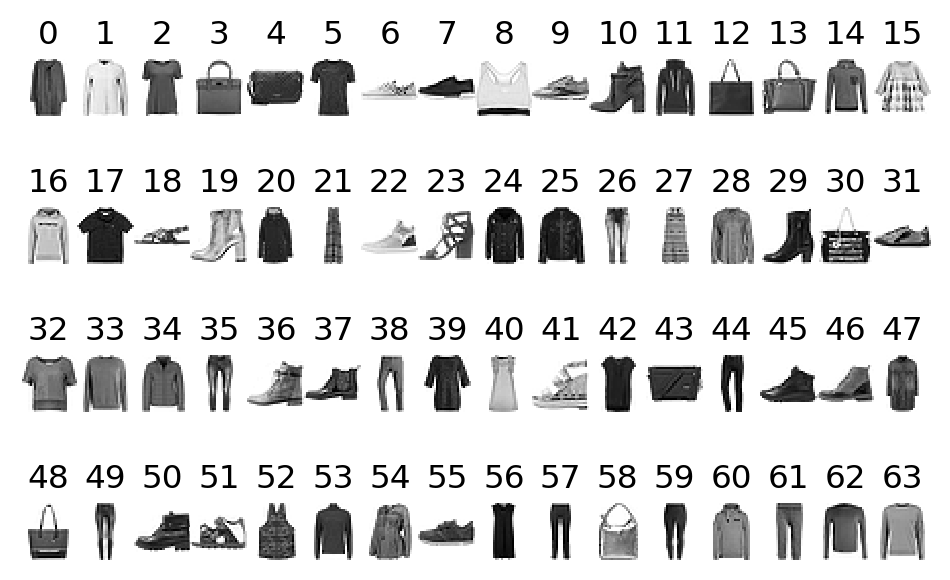

In [8]:
images, labels = next(iter(test_ds))
display_images(images=images[0:64], rows=4, cols=16, dpi=196, labels=range(images.shape[0]))

In [9]:
# A Convolutional Auto-Encoder
class ConvAutoEncoder(tf.keras.Model):
    def __init__(self, latent_dim, input_shape):
        super(ConvAutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(name='encoder',
            layers = [
              tf.keras.layers.InputLayer(input_shape=(28,28,1), name='encoder/input'),
              tf.keras.layers.Conv2D(
                  filters=32, 
                  kernel_size=3, 
                  strides=(2, 2), 
                  padding='same', 
                  activation='relu', 
                  name='encoder/conv1'),
              tf.keras.layers.Conv2D(
                  filters=64, 
                  kernel_size=3, 
                  strides=(2, 2), 
                  padding='same', 
                  activation='relu', 
                  name='encoder/conv2'),
              tf.keras.layers.Flatten(name='encoder/flatten'),
              tf.keras.layers.Dense(latent_dim, name='encoder/bottleneck'),]
        )
        
        self.decoder = tf.keras.Sequential([
          tf.keras.layers.InputLayer(input_shape=(latent_dim), name='decoder/input'),
          tf.keras.layers.Dense(units=7*7*64, activation=tf.nn.relu, name='decoder/dense1'),
          tf.keras.layers.Reshape(target_shape=(7, 7, 64), name='decoder/reshape'),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding='same',
              activation='relu',
              name='decoder/deconv1'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding='same',
              activation='relu',
              name='decoder/deconv2'),
          tf.keras.layers.Conv2DTranspose(
              filters=1, 
              kernel_size=3, 
              strides=(1, 1),
              activation='sigmoid',
              padding='same', 
              name='decoder/deconv3'),])

    def call(self, inputs):
        z = self.encoder(inputs)
        x = self.decoder(z)
        return x
        
    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

In [10]:
model = ConvAutoEncoder(latent_dim=LATENT_DIM, input_shape=images.shape[1:])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

if LOADING_WEIGHTS:
    model.load_weights(SAVE_PATH)    

In [11]:
model.encoder.summary()
model.decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder/conv1 (Conv2D)       (None, 14, 14, 32)        320       
_________________________________________________________________
encoder/conv2 (Conv2D)       (None, 7, 7, 64)          18496     
_________________________________________________________________
encoder/flatten (Flatten)    (None, 3136)              0         
_________________________________________________________________
encoder/bottleneck (Dense)   (None, 10)                31370     
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder/dense1 (Dense)       (None, 3136)              34496     
___________________________________

In [27]:
# visualize generation before training
if TRAINING:
    inputs = next(iter(test_ds))

    zs = model.encoder(inputs)
    xs = model.decoder(zs)

    display_images(images=xs[0:64], rows=4, cols=16, dpi=196, labels=range(images.shape[0]))

In [28]:
if TRAINING:
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(train_ds, 
                        callbacks=[early_stop_callback],
                        epochs=MAX_EPOCHS, 
                        steps_per_epoch=np.ceil(n_training/BATCH_SIZE), 
                        validation_data=val_ds, 
                        validation_steps=np.ceil(n_val/BATCH_SIZE))
    
    plot_history(history, 
             metrics=[('mean_squared_error', 'val_mean_squared_error'), ('loss', 'val_loss')])

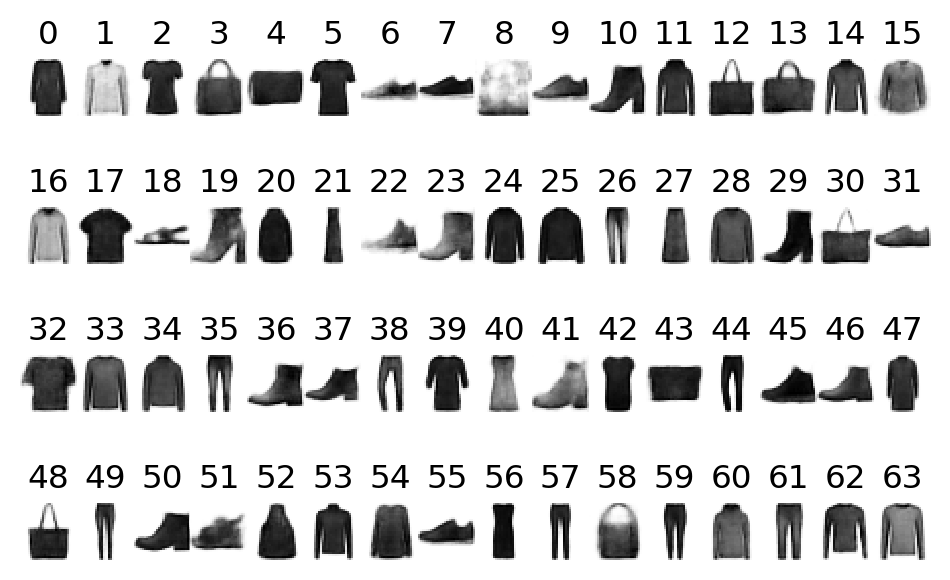

In [29]:
# visualize generation after training
inputs = next(iter(test_ds))

zs = model.encoder(inputs)
xs = model.decoder(zs)

display_images(images=xs[0:64], rows=4, cols=16, dpi=196, labels=range(images.shape[0]))

In [30]:
import scipy.spatial.distance

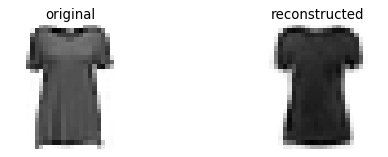

In [31]:
query_idx = 2

# original and reconstructed images
orig = images[query_idx]
recon = xs[query_idx]

display_images([orig, recon], rows=1, cols=2, dpi=80, wspace=1, labels=['original', 'reconstructed'])

# Examining Cosine Similarity of Latent Vectors

<h2>
I will be using the <i>cosine similarity (ala scipy)</i> to compare the latent vectors.

$
\begin{align}
\text{cosine similarity} \equiv 1 - \frac{\vec{u} \cdot \vec{v}}{\| u \| \| v \|}
\end{align}
$

Note that the range of this function is from $0$ (identical) to $2$ (most dissimilar).
</h2>

In [32]:
# Examples for cosine similarity distance metric

# identical vectors
u = np.random.rand(100)
v = u

scipy.spatial.distance.cosine(u, v)

0.0

In [33]:
# orthogonal vectors
u = np.random.rand(100)
v = np.random.rand(100)

# apply Gram-Schmidt to make v orthogonal to u
v -= v.dot(u) * u / np.linalg.norm(u)**2

scipy.spatial.distance.cosine(u, v)

1.0000000000000002

In [34]:
# opposite vectors
u = np.random.rand(100)
v = -u

scipy.spatial.distance.cosine(u, v)

2.0

In [35]:
dists = []
for i, z in enumerate(zs):
    dists.append([i, scipy.spatial.distance.cosine(zs[query_idx], z)])

dists = np.array(sorted(dists, key=lambda t: t[1]))

In [36]:
def format_scores(dists, indices=None, decimals=2):
    if indices is None:
        return list(map(str, np.round(dists[:,1], decimals=2)))        
    else:
        return list(map(str, np.round(dists[np.isin(dists[:,0], indices)][:,1], decimals=2)))

## Most Similar Exemplar (based on cosine similarity)

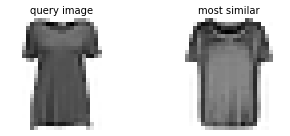

In [37]:
idx_best_match = int(dists[1,0])

display_images([orig, images[idx_best_match]], rows=1, cols=2, dpi=60, wspace=0.5, labels=['query image', 'most similar'])

## Least Similar Exemplar (based on cosine similarity)

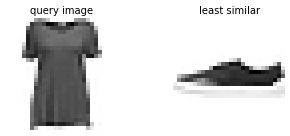

In [38]:
idx_worst_match = int(dists[-1,0])

display_images([orig, images[idx_worst_match]], rows=1, cols=2, dpi=60, wspace=0.5, labels=['query image', 'least similar'])

## All Examples _Below_ Given Threshold (with cosine similarity values)

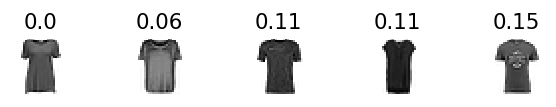

In [39]:
sim_thresh = 0.2

# indicies (of latent vectors) having cosine similarities below given threshold
indices = dists[:,0][dists[:,1] < sim_thresh].astype(int)

# cosine similaritity values (lower is closer match to query image)
scores = format_scores(dists, indices, decimals=2)

display_images(images.numpy()[indices], rows=5, cols=5, labels=scores, hspace=0.5)

## All Examples _Above_ Given Threshold (with cosine similarity values)

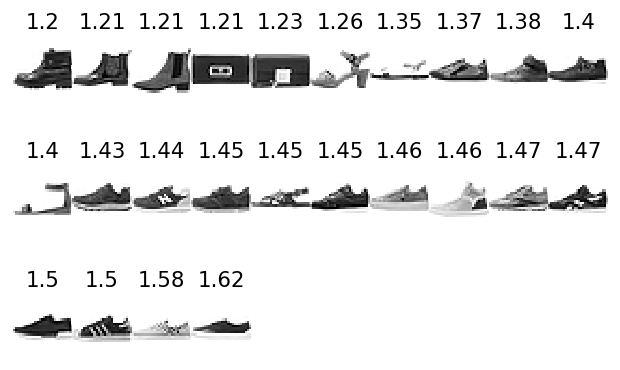

In [40]:
sim_thresh = 1.2

# indicies (of latent vectors) having cosine similarities below given threshold
indices = dists[:,0][dists[:,1] > sim_thresh].astype(int)

# cosine similaritity values (lower is closer match to query image)
scores = format_scores(dists, indices, decimals=2)

display_images(images.numpy()[indices], rows=3, cols=10, labels=scores, hspace=0.01)

In [41]:
if SAVING_WEIGHTS:
    try:
        model.save_weights(SAVE_PATH, save_format='tf')
    except Exception as e:
        print(e)